<h3 align="center">Semantic classification of scientific literature according to the hallmarks of cancer
<h3 align="center">Alan Kelly
<h3 align="center">15211915</h3>

In [1]:
import pandas as pd
import numpy as np
import os
import nltk
import random
import codecs
from sklearn.cross_validation import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, accuracy_score
from sklearn import cross_validation
from sklearn.svm import LinearSVC
from sklearn import preprocessing
import scipy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.stem import WordNetLemmatizer
from scipy.sparse import hstack
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction import FeatureHasher

In [11]:
nltk.download()

showing info http://www.nltk.org/nltk_data/


True

In [2]:
#filepath =  "C:\Users\Alan\Dropbox\Masters\Practicum\HoCCorpus\\"
filepath = 'H:\HoCCorpus'

os.chdir(filepath)
os.getcwd()

'H:\\HoCCorpus'

In [3]:
#Define the hallmarks in a list to extract from files
hallmarks = ["'sustaining proliferative signaling'","'evading growth suppressors'","'resisting cell death'","'enabling replicative immortality'",
             "'inducing angiogenesis'","'activating invasion and metastasis'","'genomic instability and mutation'","'tumor promoting inflammation'",
             "'cellular energetics'","'avoiding immune destruction'"]

In [5]:
#Removes nested lists from a list
def flatten(container):
    for i in container:
        if isinstance(i, (list,tuple)):
            for j in flatten(i):
                yield j
        else:
            yield i

In [6]:
#The tags from a specific abstract/text file
def tags(fil):
    lst = []
    with open(fil) as f:
        for line in f:
            tag = line.partition('\t[')[-1].rpartition(']')[0]
            if tag != "":
                lst.append((tag.split(",")))
    
    tag = []
    for i in list(flatten(lst)):
        i = i.strip()
        if i in hallmarks:
            tag.append(i)
    return tag

print tags('21188035.txt')

["'evading growth suppressors'", "'sustaining proliferative signaling'", "'evading growth suppressors'", "'sustaining proliferative signaling'", "'evading growth suppressors'", "'sustaining proliferative signaling'"]


In [7]:
#Functions to strip punctuation, tokenis & POS tag sentences
from string import punctuation
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

def preprocess(document):
    sentences = strip_punctuation(document)
    sentences = nltk.sent_tokenize(sentences)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    sentences = [nltk.pos_tag(sent) for sent in sentences]
    return sentences

In [8]:
#Converts nltk pos tags to lemmatizer pos tags
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [9]:
def find_bigrams(input_list):
    bigram_list = []
    for i in range(len(input_list)-1):
        bigram_list.append((input_list[i], input_list[i+1]))
    return bigram_list

In [10]:
#Function to remove tags from annotated documents
def removetag(line):
    tag = line.partition('\t[')[-1].rpartition(']')[0]
    line = line.replace(tag, "")
    line = line.replace(".\t[]\n", "")
    return line

In [12]:
#Medical Subject Headings(MeSH) & Chemical lists(Chem)
#Creates a dataframe with Mesh and Chem features

os.chdir('H:\HoC_Preprocessed\\absMeta')


def MeshChem(path):
    for root, dir_names, file_names in os.walk(path):
        for file_name in file_names:
            f = open(file_name).read()
            split = f.split("~~~mesh:")
            split = split[1].split("~~~chem:")
            split = [s.strip() for s in split]
            split = [w.replace('\n', ',') for w in split]
            mesh = split[0].lower()
            chem = split[1].lower()
            yield file_name.strip('.absmeta'), mesh, chem

def mc_df(path):
    rows = []
    index = []
    for file_name, mesh, chem in MeshChem(path):
        rows.append({'Mesh': mesh, 'Chem': chem})
        index.append(file_name)

    meshchem_df = pd.DataFrame(rows, index=index)
    return meshchem_df

meshchem_df = mc_df(os.getcwd())
meshchem_df.head()

,Chem,Mesh
11724768,2-(2-amino-3-methoxyphenyl)-4h-1-benzopyran-4-...,"animals,blotting, western,carcinoma, hepatocel..."
11773160,"antineoplastic agents,biological markers,cell ...","administration, oral,adult,aged,antineoplastic..."
11774243,"antigens, neoplasm,hepatitis b antibodies,hepa...","adoptive transfer,animals,antigens, neoplasm,b..."
11781072,"antigens, cd28,antigens, cd3,transforming grow...","antigen presentation,antigens, cd28,antigens, ..."
11791181,"culture media, conditioned,drug combinations,l...","animals,autocrine communication,breast neoplas..."


In [14]:
#Verb classes (VC)
#Creates a dataframe for verb classes features

os.chdir('H:/HoC_Preprocessed/vc')

def vc(path):
    for root, dir_names, file_names in os.walk(path):
        for file_name in file_names:
            f = open(file_name).read()
            v = f.split()
            #v = f.translate(None, '\t\n ')
            v = [x for x in v if x != '~~~']
            v = ' '.join(v)
            yield file_name.strip('.vc.txt'), v

def vc_df(path):
    rows = []
    index = []
    for file_name, v in vc(path):
        rows.append({'Verb classes': v})
        index.append(file_name)

    vc_df = pd.DataFrame(rows, index=index)
    return vc_df

vc_df = vc_df(os.getcwd())

In [ ]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(Xtra, ytra)
pred = dtc.predict(Xtes)

print 'train on %d instances, test on %d instances' % (Xtra.shape[0], Xtes.shape[0])
print "Decision Tree Classifier accuracy: %.3f"  % dtc.score(Xtes,ytes)
print accuracy_score(ytes, pred)
print classification_report(ytes, pred, target_names=hallmarks)

In [ ]:
from sklearn.feature_extraction import FeatureHasher
fh = FeatureHasher(input_type='string')
x = fh.transform(((' '.join(x) for x in sample) for sample in feats['N-bigrams']))
x

In [17]:
#Creates a dataframe containing Lemmatised Bag of Words feature and tag for each line
wnl = WordNetLemmatizer()

def lemsen(path):
    for root, dir_names, file_names in os.walk(path):
        for file_name in file_names:
            f = codecs.open(file_name, encoding = 'utf-8')
            for line in f:
                tag = line.partition('\t[')[-1].rpartition(']')[0]
                if tag != "":
                    lem = []
                    classif = []
                    classif.append(tag.split(", "))
                    #classif = [w.strip() for w in classif]
                    classif = list(flatten(classif))
                    cont = line.replace(".\t[]\n", "")
                    cont = cont.replace(tag, "")
                    cont = strip_punctuation(cont)
                    cont = cont.strip()
                    sent = nltk.word_tokenize(cont)
                    sent = [w.lower() for w in sent]
                    sent =  nltk.pos_tag(sent)
                    #classif.append(tag)
                    for j,k in sent:
                        lem.append(wnl.lemmatize(j,get_wordnet_pos(k)))
                    lem = ' '.join(lem)
                    yield file_name.strip('.txt'), lem, classif
                    
def lemsendf(path):
    rows = []
    index = []
    for file_name, lem, classif in lemsen(path):
        rows.append({'LemSen': lem, 'Class': classif})
        index.append(file_name)

    lemsendf = pd.DataFrame(rows, index=index)
    return lemsendf

fpath = 'H:/HoCCorpus//'
os.chdir(fpath)
lensem_df = lemsendf(os.getcwd())
lensem_df.head()

,Class,LemSen
11724768,['sustaining proliferative signaling'],exposure of these cell to ghrelin cause upregu...
11773160,['sustaining proliferative signaling'],zd1839 suppress egfr phosphorylation in all eg...
11773160,['sustaining proliferative signaling'],in addition zd1839 inhibit mapk activation p l...
11773160,"['resisting cell death', 'evading growth suppr...",concomitantly zd1839 increase the expression o...
11773160,['sustaining proliferative signaling'],conclusion zd1839 inhibit egfr activation and ...


In [18]:
#Noun Bigrams
#Creates a dataframe containing Noun Bigrams feature
def nbigramlin(path):
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            rdfile(os.path.join(root, path))
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            if os.path.isfile(file_path):
                f = codecs.open(file_path, encoding = 'utf-8' )
                for line in f:
                    input_list = []
                    tag = line.partition('\t[')[-1].rpartition(']')[0]
                    if tag != "":
                        word = line.lower()
                        word = word.replace(tag, "")
                        word = word.replace(".\t[]\n", "")
                        word = strip_punctuation(word)
                        word = nltk.word_tokenize(word)            
                        word = nltk.pos_tag(word)
                        #words.append((word,tag))

                        for i, (a, b) in enumerate(word):
                            if b.startswith('NN'): 
                                input_list.append(a.encode('utf-8'))
                            a= find_bigrams(input_list)
                        yield file_name.strip('.txt'),a

def nbigramlindf(path):
    rows = []
    index = []
    for file_name,a in nbigramlin(path):
        rows.append({'N-bigrams': a})
        index.append(file_name)

    n_bigramdf = pd.DataFrame(rows, index=index)
    return n_bigramdf


pth = "H:/test//"
os.chdir(fpath)
nbgramlindf = nbigramlindf(os.getcwd())

In [19]:
#Named Entities
##Creates a dataframe containing Named Entities feature
nepath = 'H:/HoC_Preprocessed/NER/'
altpath = 'H:/HoCCorpus'
test = 'H:/test//'
os.chdir(nepath)
def nel(path):
    for root, dir_names, file_names in os.walk(path):
        for file_name in file_names:
            f = open(file_name).read()
            ne = f.replace('\n', ' ')
            ne = ne.split('~~~')
            del ne[-1]
            for n in ne:
                ne =[]
                ne.append([word for word in n.split() if word[-1] == ":"])
                ne = [wor.replace(":", "") for wor in flatten(ne)]
                #ne = n.split(' ', 1)[0]
                #ne = n.replace(":", "")
                ne = ' '.join(ne)
                ne = ne.replace(' ', ', ')
                yield file_name.strip('.ner.txt'), ne
                    
                            
def nelindf(path):
    rows = []
    index = []
    for file_name, ne in nel(path):
        rows.append({'Named Entities': ne})
        index.append(file_name)

    nedf = pd.DataFrame(rows, index=index)
    return nedf

nelindf = nelindf(os.getcwd())

In [20]:
#Combine named entities with all the lines to trim for tagged lines

def allines(path):
    for root, dir_names, file_names in os.walk(path):
        for file_name in file_names:
            f = codecs.open(file_name, encoding = 'utf-8')
            for line in f:
                content = []
                tag = line.partition('\t[')[-1].rpartition(']')[0]
                cont = line.replace(".\t[]\n", "")
                cont = cont.replace(tag, "")
                cont = strip_punctuation(cont)
                cont = cont.strip()
                
                content.append(cont)
                #f.close()

                yield file_name.strip('.txt'), content, tag
                
                    
def allinesdf(path):
    rows = []
    index = []
    for file_name, content, tag in allines(path):
        rows.append({'Lines': content, 'Tag': tag})
        index.append(file_name)

    lemsendf = pd.DataFrame(rows, index=index)
    return lemsendf

fpath = 'H:/HoCCorpus//'
os.chdir(fpath)
allinedf = allinesdf(os.getcwd())
print allinedf.shape
allinedf.head(n=10)

(14923, 2)


,Lines,Tag
11724768,[Ghrelin was identified in the stomach as an e...,
11724768,[GHSR is found in various tissues but its fun...,
11724768,[Here we show that GHSR is found in hepatoma c...,
11724768,[Exposure of these cells to ghrelin caused upr...,'sustaining proliferative signaling'
11724768,[Unlike insulin ghrelin inhibited Akt kinase ...,
11724768,[These findings raise the possibility that ghr...,
11773160,[PURPOSE The epidermal growth factor receptor ...,
11773160,[We studied the pharmacodynamic effects of ZD1...,
11773160,[PATIENTS AND METHODS We studied 104 pre andor...,
11773160,[We measured ZD1839 effects on EGFR activation...,


In [21]:
#Join all lines and named entities, trim to relevant information
allinedf.reset_index(inplace = True)
nelindf.reset_index(inplace = True)

frames = [allinedf, nelindf]
namedents = pd.concat(frames, axis = 2)
#namedents = namedents.dropna(axis=['Tag']) 
filter = namedents["Tag"] != ""
namedents = namedents[filter]
namedents = namedents.drop(namedents.columns[[0,2,3]], axis = 1)
namedents = namedents.drop(namedents.columns[[0]], axis = 1)
#namedents = namedents.apply(lambda x: x.str.strip()).replace('', 'None')
namedents['Named Entities'] = namedents['Named Entities'].fillna('')

print namedents.shape
namedents.head(n=10)

(4448, 1)


,Named Entities
3,"protein, protein, protein, protein, protein"
13,"protein, cell_type"
14,protein
15,protein
17,protein
29,
32,protein
33,"protein, cell_type, cell_type"
35,"cell_type, protein, protein"
36,cell_type


In [22]:
#Combine all features into one dataframe (featsl)

lensem_df.reset_index(inplace = True)
nbgramlindf.reset_index(inplace = True)
meshchem_df.reset_index(inplace = True)
namedents.reset_index(inplace = True)
vc_df.reset_index(inplace = True)

featsl = pd.merge(lensem_df, nbgramlindf, left_index=True, right_index=True)
featsl = pd.merge(featsl,meshchem_df, left_on = ['index_x'],right_on =  ['index'])
featsl = pd.merge(featsl,vc_df, left_on = ['index_x'],right_on =  ['index'])
featsl = pd.merge(featsl, namedents, left_index=True, right_index=True)
#col = feats['class']
#feats.drop(labels=['class'], axis=1,inplace = True)
#feats.insert(3, 'class', col)

featsl  = featsl.drop(featsl.columns[[3, 5, 8, 10]], axis=1)
print featsl.shape
featsl.head()

(4448, 7)


,Class,LemSen,N-bigrams,Chem,Mesh,Verb classes,Named Entities
0,['sustaining proliferative signaling'],exposure of these cell to ghrelin cause upregu...,"[(exposure, cells), (cells, upregulation), (up...",2-(2-amino-3-methoxyphenyl)-4h-1-benzopyran-4-...,"animals,blotting, western,carcinoma, hepatocel...",G2 G2.6 G2.6.0 G5 G5.16 G5.16.0 G3 G3.1 G3.1.7...,"protein, protein, protein, protein, protein"
1,['sustaining proliferative signaling'],zd1839 suppress egfr phosphorylation in all eg...,"[(zd1839, egfr), (egfr, phosphorylation), (pho...","antineoplastic agents,biological markers,cell ...","administration, oral,adult,aged,antineoplastic...",G2 G2.1 G2.1.1 G2 G2.1 G2.1.1 B5 B5.1 B5.1.10 ...,"protein, cell_type"
2,['sustaining proliferative signaling'],in addition zd1839 inhibit mapk activation p l...,"[(addition, zd1839), (zd1839, mapk), (mapk, ac...","antineoplastic agents,biological markers,cell ...","administration, oral,adult,aged,antineoplastic...",G2 G2.1 G2.1.1 G2 G2.1 G2.1.1 B5 B5.1 B5.1.10 ...,protein
3,"['resisting cell death', 'evading growth suppr...",concomitantly zd1839 increase the expression o...,"[(zd1839, expression), (expression, p27kip1), ...","antineoplastic agents,biological markers,cell ...","administration, oral,adult,aged,antineoplastic...",G2 G2.1 G2.1.1 G2 G2.1 G2.1.1 B5 B5.1 B5.1.10 ...,protein
4,['sustaining proliferative signaling'],conclusion zd1839 inhibit egfr activation and ...,"[(conclusion, zd1839), (zd1839, egfr), (egfr, ...","antineoplastic agents,biological markers,cell ...","administration, oral,adult,aged,antineoplastic...",G2 G2.1 G2.1.1 G2 G2.1 G2.1.1 B5 B5.1 B5.1.10 ...,protein


In [23]:
import gc 
gc.collect()

407

In [24]:
columns = ["LemSen", "N-bigrams", "Chem", "Mesh", "Named Entities", 'Verb classes']
features = featsl[list(columns)].values
labels = featsl["Class"].values
mlb = preprocessing.MultiLabelBinarizer()
vectorizer = CountVectorizer(min_df=1)
fh = FeatureHasher(input_type='string')
hv = HashingVectorizer(n_features=10)

labels = mlb.fit_transform(labels)

X = vectorizer.fit_transform(features[:,0])
X2 = fh.transform(((' '.join(x) for x in sample) for sample in features[:,1]))  ##Need to vectorize this better
X3 = vectorizer.fit_transform(features[:,2])
X4 = vectorizer.fit_transform(features[:,3])
#X4 = vectorizer.fit_transform([f for f in features[:,3]])
X5 = vectorizer.fit_transform((features[:,4]))
X6 = fh.fit_transform((features[:,5]))
Xall = hstack((X, X2, X3, X4, X5, X6))
Xtra, Xtes, ytra, ytes = cross_validation.train_test_split(Xall,labels, test_size=0.25)

clf = OneVsRestClassifier(LinearSVC(random_state=0))
clf.fit(Xtra, ytra)
predicted = clf.predict(Xtes)

print 'train on %d instances, test on %d instances' % (Xtra.shape[0], Xtes.shape[0])
print "One vs rest Linear SVM accuracy: %.3f"  % clf.score(Xtes,ytes)
print accuracy_score(ytes, predicted)
print classification_report(ytes, predicted, target_names=hallmarks)

train on 3336 instances, test on 1112 instances
One vs rest Linear SVM accuracy: 0.754
0.753597122302
                                      precision    recall  f1-score   support

'sustaining proliferative signaling'       0.93      0.86      0.89       158
        'evading growth suppressors'       0.90      0.78      0.83        58
              'resisting cell death'       0.91      0.88      0.89        48
  'enabling replicative immortality'       0.95      0.75      0.84        73
             'inducing angiogenesis'       0.91      0.72      0.80       108
'activating invasion and metastasis'       0.96      0.85      0.90       197
  'genomic instability and mutation'       0.87      0.81      0.84        95
      'tumor promoting inflammation'       0.88      0.93      0.90       203
               'cellular energetics'       0.85      0.82      0.84       257
       'avoiding immune destruction'       0.92      0.81      0.86       121

                         avg / total  

In [25]:
from sklearn import metrics
print metrics.jaccard_similarity_score(ytes, predicted)
print metrics.roc_auc_score(ytes, predicted, average='weighted')

0.826049160671
0.907784160828


In [179]:
#Optimizing the parameters for RBF kernel in SVM
clf = OneVsRestClassifier(svm.SVC(kernel='rbf'))
params = {"estimator__C":[23, 24, 25], "estimator__gamma": [0.0011, 0.001, 0.0009]}
grid_search = GridSearchCV(clf, params)
grid_search.fit(Xall,labels)

print grid_search.get_params()
print grid_search.best_score_
print grid_search.best_params_

{'estimator__estimator': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False), 'n_jobs': 1, 'estimator__estimator__random_state': None, 'estimator__estimator__C': 1.0, 'estimator__estimator__shrinking': True, 'estimator__estimator__max_iter': -1, 'estimator__estimator__verbose': False, 'estimator__estimator__class_weight': None, 'estimator__estimator__cache_size': 200, 'param_grid': {'estimator__C': [23, 24, 25], 'estimator__gamma': [0.0011, 0.001, 0.0009]}, 'cv': None, 'verbose': 0, 'scoring': None, 'estimator__estimator__probability': False, 'estimator__n_jobs': 1, 'estimator__estimator__coef0': 0.0, 'estimator__estimator__kernel': 'rbf', 'fit_params': {}, 'refit': True, 'iid': True, 'estimator__estimator__degree': 3, 'score_func': None, 'pre_dispatch': '2*n_jobs', 'estimator__estimator__gamma': 0.0, 'loss_func': None, 'estimator': OneVsRestClassifie

In [26]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn import svm, grid_search
clf = OneVsRestClassifier(svm.SVC(C=25.0, kernel='rbf', gamma = 0.0009))
clf.fit(Xtra, ytra)
predicted = clf.predict(Xtes)

print 'train on %d instances, test on %d instances' % (Xtra.shape[0], Xtes.shape[0])
print "One vs rest SVM (RBF Kernel) accuracy: %.3f"  % clf.score(Xtes,ytes)
print accuracy_score(ytes, predicted)
print classification_report(ytes, predicted, target_names=hallmarks)

train on 3336 instances, test on 1112 instances
One vs rest SVM (RBF Kernel) accuracy: 0.665
0.664568345324
                                      precision    recall  f1-score   support

'sustaining proliferative signaling'       0.83      0.78      0.81       158
        'evading growth suppressors'       0.93      0.71      0.80        58
              'resisting cell death'       0.86      0.75      0.80        48
  'enabling replicative immortality'       0.84      0.71      0.77        73
             'inducing angiogenesis'       0.80      0.51      0.62       108
'activating invasion and metastasis'       0.90      0.79      0.84       197
  'genomic instability and mutation'       0.83      0.76      0.79        95
      'tumor promoting inflammation'       0.89      0.75      0.82       203
               'cellular energetics'       0.81      0.77      0.79       257
       'avoiding immune destruction'       0.74      0.64      0.68       121

                         avg / t

In [27]:
from sklearn.cross_validation import cross_val_predict

clf = OneVsRestClassifier(LinearSVC())
#clf = OneVsRestClassifier(svm.SVC(C=25.0, kernel='rbf', gamma = 0.0009))
scores = cross_validation.cross_val_score(clf, Xall,labels, cv=4)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#print scores

y_pred = cross_val_predict(clf, Xall, labels, cv=4)
print y_pred.shape
print(classification_report(labels, y_pred, target_names=hallmarks))

Accuracy: 0.62 (+/- 0.06)
(4448, 10)
                                      precision    recall  f1-score   support

'sustaining proliferative signaling'       0.93      0.82      0.87       667
        'evading growth suppressors'       0.75      0.50      0.60       226
              'resisting cell death'       0.95      0.75      0.84       213
  'enabling replicative immortality'       0.94      0.69      0.80       295
             'inducing angiogenesis'       0.70      0.48      0.57       368
'activating invasion and metastasis'       0.92      0.81      0.86       771
  'genomic instability and mutation'       0.89      0.71      0.79       357
      'tumor promoting inflammation'       0.94      0.80      0.86       833
               'cellular energetics'       0.78      0.67      0.72       993
       'avoiding immune destruction'       0.87      0.68      0.76       520

                         avg / total       0.87      0.72      0.79      5243



In [28]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(Xtra, ytra)
pred = dtc.predict(Xtes)

print 'train on %d instances, test on %d instances' % (Xtra.shape[0], Xtes.shape[0])
print "Decision Tree Classifier accuracy: %.3f"  % dtc.score(Xtes,ytes)
print accuracy_score(ytes, pred)
print classification_report(ytes, pred, target_names=hallmarks)

train on 3336 instances, test on 1112 instances
Decision Tree Classifier accuracy: 0.674
0.674460431655
                                      precision    recall  f1-score   support

'sustaining proliferative signaling'       0.87      0.81      0.84       158
        'evading growth suppressors'       0.66      0.57      0.61        58
              'resisting cell death'       0.76      0.67      0.71        48
  'enabling replicative immortality'       0.88      0.77      0.82        73
             'inducing angiogenesis'       0.69      0.61      0.65       108
'activating invasion and metastasis'       0.86      0.82      0.84       197
  'genomic instability and mutation'       0.77      0.76      0.77        95
      'tumor promoting inflammation'       0.84      0.84      0.84       203
               'cellular energetics'       0.74      0.73      0.74       257
       'avoiding immune destruction'       0.69      0.65      0.67       121

                         avg / total

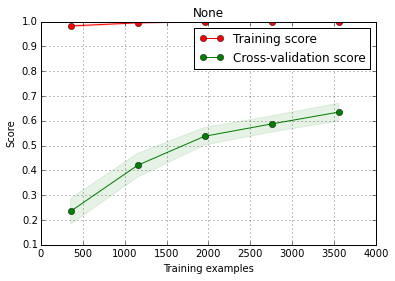

In [29]:
from sklearn.learning_curve import learning_curve
import matplotlib.pyplot as plt
%matplotlib inline

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt.show()

plot_learning_curve(clf, None, Xall, labels, cv=5)